### imports

In [30]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import collections
from string import punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eiloneil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### functions

In [31]:
pd.set_option('display.max_rows', None)

# Set up irrelevant stopwords
puncs =  list(punctuation)# list(',.\/?!@#$%^&*()-')
sw = set(stopwords.words('english'))

# Remove all punctuation symbols
def clear_punc(txt):
    for p in puncs:
        txt = txt.replace(p, '')
    return txt

# Filter out SWs from text
def filter_out_stopwords(txt):
    return list(filter(lambda w: not (w.lower() in sw), txt.split()))

# dict by text WITHOUT STOPWORDS
def to_dict_of_lsts(txt_lst, remove_stop_words=False):
    if remove_stop_words:
        return {i+1:filter_out_stopwords(txt) for i, txt in enumerate(txt_lst)}
        print('REMOVED')
    else:
        return {i+1:txt.split() for i, txt in enumerate(txt_lst)}


# Count tokens per text
def count_tokens_per_text(dict_tokens):
    return {i:dict(collections.Counter(tokens)) for i, tokens in dict_tokens.items()}


# Count instances per each text and token, and save as pd.DataFrame
def counter_df_by_token_doc(dict_counter):
    dfs = [pd.DataFrame({'Token':counters.keys(), 'Frequency': counters.values(), 'Doc': [text_i] * len(counters)}) for text_i, counters in dict_counter.items()]
    return pd.concat(dfs, ignore_index=True).sort_values(['Doc', 'Frequency'], ascending=[True, False], ignore_index=True)


# Count instances per each token
def counter_df_by_token(df_per_doc_token):
    df = df_per_doc_token.groupby('Token')['Frequency'].sum().reset_index()
    return df.sort_values('Frequency', ascending=False, ignore_index=True)


### main funcs

In [44]:

# Combination of all functions
def get_words_by_freq(texts_lst:list[str], *args, **kwargs):
    """
    Takes list of texts and returns the number of instances 
    of every word (token), per text source (doc) and in total
    
    :texts_lst: List of strings. Each string is a text source (doc)
    
    :kwargs:
    :remove_stop_words: Bool. Indicates whether to remove common stop-words (e.g. "and", "the" etc.) or not
    :remove_punc: Bool. Indicates whether to remove punctuation marks (e.g. "@", "?", "." etc.) or not
    
    :return type: Dict of pd.DataFrames:
    :'df_per_doc_token': DF that shows the distribution of the words (# num of instances 
    as "Frequency" column) grouped by the text source ("Doc" column)
    :'df_per_token': DF that shows the distribution of the words (# num of instances 
    as "Frequency" column) in total, across all text sources
    """
    dfs = {}
    remove_stop_words = kwargs.get('remove_stop_words')
    remove_punc = kwargs.get('remove_punc')
    
    if remove_punc:
        texts_lst = list(map(clear_punc, texts_lst))
    
    # dict by text WITHOUT STOPWORDS
    dict_tokens = to_dict_of_lsts(texts_lst, remove_stop_words=remove_stop_words)

    # Count tokens per text
    dict_counter = count_tokens_per_text(dict_tokens)

    # Count instances per each text and token, and save as pd.DataFrame
    df_per_doc_token = counter_df_by_token_doc(dict_counter)
    dfs['df_per_doc_token'] = df_per_doc_token

    # Count instances per each token
    df_per_token = counter_df_by_token(df_per_doc_token)
    dfs['df_per_token'] = df_per_token
    
    return dfs



# main

def main(texts_lst, *args, **kwargs):
    try:
        dfs = get_words_by_freq(texts_lst, *args, **kwargs)
        return dfs
    except Exception as e:
        print(e)

### initial text docs

In [52]:
# Sample text
D1 = "The quick brown fox jumped over the lazy dog"
D2 = "But why did the fox jump over the dog ?"
D3 = "Calling the dog lazy is not very nice ."

# All texts
texts_lst = [D1, D2, D3]

try:
    articles = get_article()
    physics_article = articles.get('physics')
    bio_article = articles.get('biology')
except:
    raise Exception('get_article function is defined below.\nRun its cell and rerun "initial text docs" cell\nand continue')

## Run main

In [53]:
if __name__ == '__main__':
    dfs = main(texts_lst, remove_stop_words=True, remove_punc=True)

    print("Show every token's frequency in each doc")
    display(dfs['df_per_doc_token'])

    print("Show every token's frequency in all docs, sorted")
    display(dfs['df_per_token'])

Show every token's frequency in each doc


,Token,Frequency,Doc
0,quick,1,1
1,brown,1,1
2,fox,1,1
3,jumped,1,1
4,lazy,1,1
5,dog,1,1
6,fox,1,2
7,jump,1,2
8,dog,1,2
9,Calling,1,3


Show every token's frequency in all docs, sorted


,Token,Frequency
0,dog,3
1,fox,2
2,lazy,2
3,Calling,1
4,brown,1
5,jump,1
6,jumped,1
7,nice,1
8,quick,1


## Plotting

In [62]:
TOP_N = 30
NAMES_OF_DOCS = ['biology', 'physics']
colors = ['red', 'blue', 'orange', 'green'] # TODO: Generate automatic colorization, without hard-coding

df_plot = main(bio_article + physics_article, remove_stop_words=True, remove_punc=True)['df_per_doc_token']
df_plot['clr'] = df_plot['Doc'].apply(lambda x: colors[x])

df_plot = df_plot.pivot_table(index='Token', columns='Doc', values='Frequency', aggfunc='sum')
df_plot['total'] = df_plot.sum(axis=1)

df_plot.sort_values('total', ascending=True, inplace=True)
df_plot = df_plot.iloc[TOP_N*-1:, :-1].fillna(0)

df_plot.head(5)

Doc,1,2
Token,,
Xray,0.0,19.0
ring,0.0,19.0
Greek,0.0,20.0
cycles,0.0,20.0
Figure,0.0,21.0


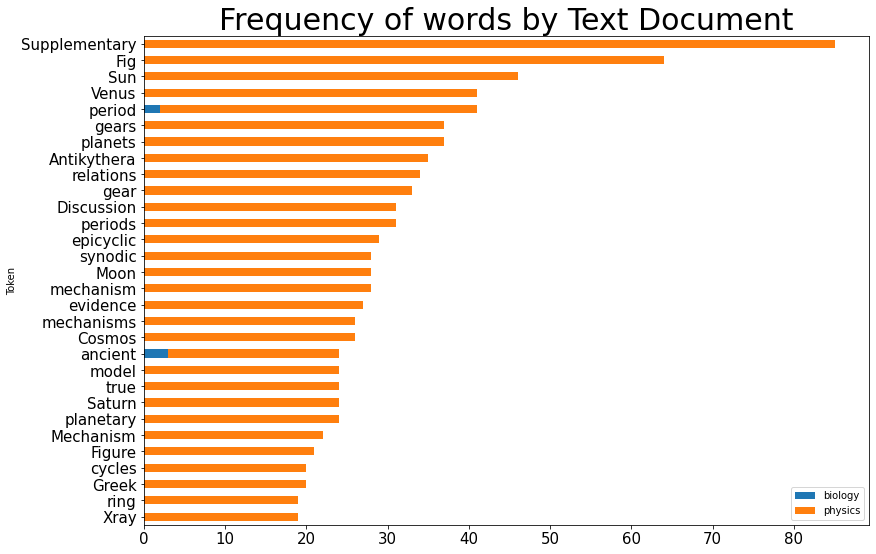

In [63]:
ax = df_plot.plot(kind='barh', stacked=True, figsize=(13,9), fontsize=15)
ax.set_title('Frequency of words by Text Document', fontsize=30)
ax.legend(NAMES_OF_DOCS)

In [51]:
def get_article():
    return {'physics': ["""
Abstract
The Antikythera Mechanism, an ancient Greek astronomical calculator, has challenged researchers since its discovery in 1901. Now split into 82 fragments, only a third of the original survives, including 30 corroded bronze gearwheels. Microfocus X-ray Computed Tomography (X-ray CT) in 2005 decoded the structure of the rear of the machine but the front remained largely unresolved. X-ray CT also revealed inscriptions describing the motions of the Sun, Moon and all five planets known in antiquity and how they were displayed at the front as an ancient Greek Cosmos. Inscriptions specifying complex planetary periods forced new thinking on the mechanization of this Cosmos, but no previous reconstruction has come close to matching the data. Our discoveries lead to a new model, satisfying and explaining the evidence. Solving this complex 3D puzzle reveals a creation of genius—combining cycles from Babylonian astronomy, mathematics from Plato’s Academy and ancient Greek astronomical theories.

Introduction
The Antikythera Mechanism is a cultural treasure that has engrossed scholars across many disciplines. It was a mechanical computer of bronze gears that used ground-breaking technology to make astronomical predictions, by mechanizing astronomical cycles and theories1,2,3,4,5,6,7,8,9. The major surviving fragments of the Antikythera Mechanism are labelled A–G and the minor fragments 1–757. They are partial, damaged, corroded and covered in accretions (Supplementary Fig. S1). Nevertheless, they are rich in evidence at the millimetre level—with fine details of mechanical components and thousands of tiny text characters, buried inside the fragments and unread for more than 2,000 years7. Fragment A contains 27 of the surviving 30 gears, with a single gear in each of Fragments B, C and D2,5,7,10. The fragments are a 3D puzzle of great complexity.

In 2005 Microfocus X-ray Computed Tomography (X-ray CT) and Polynomial Texture Mapping (PTM) of the Mechanism’s 82 fragments7 added substantial data. This led to a solution to the back of the machine4,7,8,9, with the discovery of eclipse prediction and the mechanization of the lunar anomaly7 (Supplementary Fig. S20). The front remained deeply controversial due to loss of physical evidence.

Many unsuccessful attempts have been made to reconcile the evidence with a display of the ancient Greek Cosmos of Sun, Moon and all five planets known in antiquity. In 1905–06, remarkable research notes by Rehm1 described Mein Planetarium, with a ring display for the planets that anticipates the model we present here—but mechanically completely wrong due to his lack of data (Supplementary Fig. S17). In the classic, Gears from the Greeks2, Price suggested lost gearing that calculated planetary motions, but made no attempt at a reconstruction. Then Wright built the first workable system at the front that calculated planetary motions and periods, with a coaxial pointer display of the Cosmos, proving its mechanical feasibility3 (Supplementary Fig. S18). Later attempts by Freeth and Jones9 (Supplementary Fig. S19), and independently by Carman, Thorndike, and Evans11, simplified the gearing but were limited to basic periods for the planets. Most previous reconstructions used pointers for the planetary displays, giving serious parallax problems3,9 and poorly reflecting the description in the inscriptions—see section on Inscriptional Evidence. None of these models (Supplementary Discussion S6) are at all compatible with all the currently known data.

Our challenge was to create a new model to match all the surviving evidence. Features on the Main Drive Wheel indicate that it calculated planetary motions with a complex epicyclic system (gears mounted on other gears), but its design remained a mystery. The tomography revealed a wealth of unexpected clues in the inscriptions, describing an ancient Greek Cosmos9 at the front, but attempts to solve the gearing system failed to match all the data1,2,3,6,9. The evidence defines a framework for an epicyclic system at the front9, but the spaces available for the gears are extremely limited. There were also unexplained components in Fragment D, revealed by the X-ray CT, and technical difficulties calculating the phase of the Moon9. Then came the discovery in the tomography of surprisingly complex periods for the planets Venus and Saturn, making the task very much harder12.

Discussion and results
We wanted to determine the cycles for all the planets in this Cosmos (not just the cycles discovered for Venus and Saturn); to incorporate these cycles into highly compact mechanisms, conforming to the physical evidence; and to interleave them so their outputs correspond to the customary cosmological order (CCO), described below. Here we show how we have created gearing and a display that respects the inscriptional evidence: a ring system with nine outputs—Moon, Nodes, Mercury, Venus, Sun, Mars, Jupiter, Saturn and Date—carried by nested tubes with arms supporting the rings. The result is a radical new model that matches all the data and culminates in an elegant display of the ancient Greek Cosmos. With so much missing, we ensure the integrity of our model with a strict set of Reconstruction Principles (Supplementary Discussion S1) and we assess the strength of data that validates each element—discussed in Supplementary Discussion S1. The loss of evidence might suggest many options for a model. What has struck us forcefully in making the present model is just how few these options are: the constraints created by the surviving evidence are stringent and very difficult to meet.

Inscriptional evidence
Reconstructing the Cosmos at the front of the Antikythera Mechanism begins with analysing some remarkable inscriptions. Figure 1 shows the Front and Back Cover Inscriptions (FCI & BCI)9,12,13, which are critical for understanding this Cosmos. For previous analysis13 and our own line-by-line exploration of the BCI, see Supplementary Discussion S2. The BCI describes the front display as a Planetarium9,13: a Cosmos arranged in rings, with planets marked by “little spheres” and the Sun as a “little golden sphere” with “ray” and “pointer” (Fig. 1c, Supplementary Table S1, Supplementary Figs. S2, S3). The FCI lists the synodic cycles of the planets (cycles relative to the Sun)12. This is a systematic list, itemizing the synodic events and the intervals in days between them. The planets are written in the same geocentric order as the BCI. Adding Moon and Sun gives the customary cosmological order (CCO): Moon, Mercury, Venus, Sun, Mars, Jupiter, Saturn (Supplementary Fig. S4), whose origins are discussed in Supplementary Discussion S2.

Figure 1
figure 1
Inscriptions on the Antikythera mechanism. (a) FRONT COVER: Planet cycles9,12, framed by moulding from Fragment 3 (Supplementary Fig. S5). FRONT PLATE: Parapegma1,2,25, above and below the Cosmos Display, indexed to the Zodiac Dial. BACK PLATE: Month names on the Metonic Calendar4,8. Eclipse characteristics, round Metonic Calendar and Saros Eclipse Prediction Dials7,8—indexed to the latter. Eclipse glyphs indexed to the Saros Dial8. BACK COVER: User Manual, including Cosmos description9,13 (Supplementary Discussion S2), Calendar Structure8 and Moon-Sun Cycles1,2. (b) Front Cover Inscription (FCI): composite X-ray CT from Fragments G, 26 and 29 and other small fragments9,12. The FCI describes synodic cycles of the planets and is divided into regions for each planet in the CCO (Supplementary Discussion S2). The numbers ϒΞΒ (462) in the Venus section and ϒMΒ (442) in the Saturn section are highlighted12 (Supplementary Fig. S4). (c) Back Cover Inscription (BCI)13 (Supplementary Discussion S2): composite X-ray CT from Fragments A and B. A User Manual: the upper part is a description of the front Cosmos Display9 with planets in the CCO; in red are the planet names as well as the word KOΣMOY—“of the Cosmos”.

Full size image
Period relations and ancient Greek theories
Ancient astronomers were fascinated by the motions of the planets. As seen from Earth, they exhibit periodic reversals of motion against the stars14. In Babylonian astronomy these synodic cycles were the basis of planetary prediction15, utilizing period relations, such as 5 synodic cycles in 8 years for Venus, which we denote by (5, 8). The FCI describes synodic events, such as stationary points, and intervals between these events (Fig. 1b, Supplementary Fig. S4, Supplementary Discussion S2).

Apollonios of Perga (third-second century BC) created elegant (albeit inaccurate) epicyclic theories to explain these anomalous movements as the sum of two uniform circular motions, their periods defined by period relations—the deferent and epicycle models15 (Supplementary Discussion S3, Supplementary Figs. S6, S7, S8). Such theories were certainly employed in the Antikythera Mechanism, given that the Moon was mechanized using a similar epicyclic theory7. The true Sun—the Sun with its variable motion—was also explained in ancient Greece by eccentric and equivalent epicyclic models14 (Supplementary Discussion S3).

Babylonian texts list planetary periods and their errors: shorter, less accurate periods in Goal-Year Texts (GYT) and longer, more accurate periods in later Astronomical Cuneiform Texts (ACT)15 (Supplementary Tables S3, S4). The GYT periods could have been derived from observations, but not the longer ACT periods, such as (720, 1151) for Venus (Supplementary Discussion S3). To understand what period relations were built into the Antikythera Mechanism, the tough problem was to discover their derivation. For Venus the original designer faced a dilemma: the known period relation (5, 8) was very inaccurate, whereas the accurate (720, 1151) was not mechanizable because 1151 is a prime number, requiring a gear with 1151 teeth. Then came a notable discovery in 2016 in the FCI12: unexpected numbers ϒΞΒ (462) in the Venus section of the FCI and ϒMΒ (442) in the Saturn section, translating into highly accurate period relations: for Venus (289, 462) and Saturn (427, 442) (Fig. 1b, Supplementary Fig. S4). Crucially, these are factorizable, meaning they can be mechanized with moderate-sized gears, with tooth counts incorporating the prime factors of the period relations. To fit the geometry of the epicyclic system, mechanisms must have gears with < 100 teeth: period relations must have prime factors < 100 (Supplementary Discussion S3. There are few such accurate period relations for the planets (Supplementary Tables S5, S6).

The fact that the new period relations for Venus and Saturn from the FCI are factorizable strongly reinforces the idea that they were incorporated into planetary mechanisms in the Antikythera Mechanism16. The periods for the other planets are unreadable (in missing or damaged areas of the FCI). To build our model, it was essential to discover the period relations embodied in all the planetary mechanisms. Previous publications12,16 derived the Venus period relation (289, 462) as an iterative approximation to the known Babylonian (720, 1151) period relation, using a number of equivalent processes: continued fractions, anthyphairesis or the Euclidean algorithm17,18. No similar method for deriving the (427, 442) period relation for Saturn could be found, so this type of iterative approximation was almost certainly not the route to the original discoveries of these periods by the ancient Greeks.

Discovering cycles in the Antikythera Mechanism
The newly-discovered periods for Venus and Saturn are unknown from studies of Babylonian astronomy. Figure 2 explores how these periods might have been derived. Clues came from the Babylonian use of linear combinations of periods designed to cancel out observed errors14. Figure 2a shows how this might generate the periods for Venus and Saturn, but choosing the correct linear combinations essentially uses knowledge about errors in known period relations relative to the true value. The lack of fine error-estimates from antiquity excludes these methods for our model: errors like < 1° in 100 years for (720, 1151) were beyond the naked-eye astronomy of the Hellenistic age.

Figure 2
figure 2
Finding period relations. Blue numbers refer to synodic cycles; red numbers refer to years. All the seed periods for these processes are known from Babylonian astronomy (Supplementary Tables S5, S6). (a) Linear combinations of Babylonian period relations, which give those for Venus and Saturn from the FCI. (b) Period relations generated by a conventional Parmenides Process, which also give those for Venus and Saturn from the FCI. (c) Iterations of an Unconstrained Parmenides Process. (2p + 2r, 2q + 2 s) is omitted from Iteration 3 because it is the same as 2 x (p + r, q + s). (d) Three iterations of the Unconstrained Parmenides Process. The pairs in colour are those that are factorizable with prime factors < 100. The grey-shaded periods are those that are known from the FCI. Note that for Venus: (1445, 2310) ≡ (289, 462) and (735, 1175) ≡ (147, 235). The same table with errors is shown in Supplementary Table S5. (e) Periods derived from the Unconstrained Parmenides Process for our model of the Antikythera Mechanism and their errors, using our three criteria of accuracy, factorizability and economy. Except for the periods for Venus and Saturn, all the final periods were already known in Babylonian astronomy. The error parameters are defined in Supplementary Discussion S3.

Full size image
We have developed a new theory about how the Venus and Saturn periods were discovered and apply this to restore the missing planetary periods. A dialogue of Plato19 (fifth-fourth century BC) was named after the philosopher Parmenides of Elea (sixth-fifth century BC). This describes Parmenides Proposition17,18:

In approximating θ, suppose rationals, p/q and r/s, satisfy p/q < θ < r/s.

Then (p + r)/(q + s) is a new estimate between p/q and r/s:

If it is an underestimate, it is a better underestimate than p/q.

If it is an overestimate, it is a better overestimate than r/s.

Assuming it is a better underestimate, the next stage combines this with the original overestimate to create (p + 2r)/(q + 2s). This would be tested against q and the process repeated. Thus, from two seed ratios we can generate increasingly accurate linear combinations that converge to θ. The Parmenides process is facilitated and constrained by knowledge of θ to determine whether each new estimate is an under- or over-estimate. Figure 2b shows how a conventional Parmenides Process can generate our target periods, but again this relies on unavailable knowledge about errors. The key step for discovering the missing cycles is to modify the Parmenides Process, so it is not constrained by knowledge of errors—an Unconstrained Parmenides Process (UPP). Figure 2c, d show the exhaustive linear combinations that are systematically generated by this process. How should we choose which period relations are suitable for our model? Two criteria were surely used for choosing period relations: accuracy and factorizability. The necessity of fitting the gearing systems into very tight spaces and the ingenious sharing of gears in the surviving gear trains (Supplementary Fig. S20) inspires a third criterion: economy—period relations that generate economical gear trains, using shared gears, calculating synodic cycles with shared prime factors7 (Supplementary Discussions S3, S6).

Here we clarify how we believe the process was used. The designer would have generated linear combinations using the UPP. At each stage, these possible period relations would have been examined to see if they met the designer’s criteria of accuracy, factorizability and economy. Factorizability would have been an easy criterion to assess. Accuracy is more problematic, since we do not believe that ancient astronomers had the ability to make very accurate astronomical observations, as is witnessed by the Babylonian records (Supplementary Tables S3, S4). Economy must be examined in relationship with the period relations generated for the other inferior or superior planets to identify shared prime factors.

Venus is a good example. The ancient Babylonians knew that the (5, 8) period for Venus was very inaccurate and they had derived the unfactorizable (720, 1151) from observation of an error in the 8-year cycle (Supplementary Discussion S3). Such periods were often described in the ancient world as “exact periods”, though of course in modern terms this is not the case. When the factorizable period (289, 462) was discovered from the UPP, it would have been easy to calculate that it is in fact very close to the “exact period” (720, 1151). Thus, the designer would have been confident that it was an accurate period. (289, 462) would then have been compared with (1513, 480) for Mercury to discover that they shared the common factor 17 in the number of synodic cycles—meaning that they were suitable for use in a shared-gear design to satisfy the criterion of economy. When the designer had discovered period relations that matched all the criteria, the process would have been stopped, since further iterations would likely have lead to solutions of greater complexity.

The UPP, combined with our three criteria, leads to remarkably simple derivations of the Venus and Saturn period relations. For Venus, Fig. 2d shows that the first factorizable period relation is (1445, 2310) = 5 × (289, 462) ≡ (289, 462) = (172, 2 × 3 × 7 × 11), as found in the FCI. For Saturn, it is (427, 442) = (7 × 61, 2 × 13 × 17), again from the FCI. This discovery enables derivations of the missing planetary periods. To ensure our third criterion of economy, some of the prime factors of the synodic cycles must be incorporated into the first fixed gear of a planetary train (Supplementary Discussion S4). For Mercury, we are looking for a factor of 17 in the number of synodic cycles to share with Venus. The first factorizable iteration is (1513, 480) = (17 × 89, 25 × 3 × 5)—sharing the prime factor 17 with (289, 462) for Venus—so, a very good choice. Multiplying by integers to obtain viable gears leads to economical designs with a single fixed 51-tooth gear shared between Mercury and Venus (Fig. 3c, e)16. For the superior planets, Mars and Jupiter, we are looking for synodic periods that share the factor 7 with Saturn (Fig. 3d, f). Just a few iterations yield suitable synodic periods—leading to very economical designs with a single 56-tooth fixed gear for all three superior planets and the true Sun.

Figure 3
figure 3
Epicyclic Mechanisms for the Cosmos. Fixed gears are underlined; blue gears calculate synodic cycles; red gears calculate years; black gears are idler gears: all designated by their tooth counts. “ ~ ” means “meshes with”; “ + ” means “fixed to the same arbor”; “⊕” means “with a pin-and-follower, turning on the central axis” or “with a pin-and-slot on eccentric axes”—creating variable motion (turquoise). Followers are slotted rods that follow a pin on the epicyclic gear and turn on the central axis. For each mechanism, there is a fixed gear at the centre, meshing with the first epicyclic gear, which is forced to rotate by the rotation of b1 or the CP. (a) 4-gear epicyclic system for the Line of Nodes. (b) 3-gear direct model for the true Sun. (c) 5-gear direct model for an inferior planet for complex period relations, with variable motion calculated by a pin and slotted follower. (d) 7-gear indirect model for a superior planet for complex period relations, with variable motion calculated by a pin-and-slot on eccentric axes. (e) Period relations and gear trains on the Main Drive Wheel, b1; Mercury & Venus share fixed 51. (f) Period relations and gear trains on the Circular Plate, CP, sharing fixed 56; gears also shared between Saturn/true Sun and Mars/Jupiter (Supplementary Discussion S4).

Full size image
From Supplementary Table S5,S6, in Supplementary Discussion S3 we establish that the missing periods for Mercury and Mars are uniquely determined by our process. There are two additional options for Jupiter that share the prime 7 in the number of synodic cycles (Supplementary Table S6). In Supplementary Discussion S3 we show how one of these is not possible and the other is very unlikely. The UPP, combined with criteria of accuracy, factorizability and economy, explains the Venus and Saturn periods and (almost) uniquely generates the missing period relations.

Theoretical mechanisms for our model
The calculation of the Moon’s position in the Zodiac and its phase are defined by surviving physical evidence7,10. Since the evidence is missing for the Sun and planets, we need to develop theoretical mechanisms, based on our identified period relations. Figure 3 shows theoretical gear trains for the mean Sun, Nodes and the Planets.

Geometrical parameters for the planetary mechanisms in Fig. 3c, d are shown in Supplementary Table S9.

The way that the Saros Dial on the Back Plate predicts eclipses essentially involves the lunar nodes, but they are not described in the extant inscriptions. With their integral role in eclipses, a display of the nodes is a logical inclusion, unifying Front and Back Dials. To maximise the displayed information, we created a mechanism for a hypothetical Dragon Hand to indicate the Line of Nodes of the Moon, as included in many later astronomical clocks20 (Supplementary Fig. S2). We should emphasize that there is no direct physical evidence for an indication of the Line of Nodes of the Moon. We have added this feature as a hypothetical element for the thematic reasons already explained and because it is easily mechanized to good accuracy with a simple 4-gear epicyclic system on Spoke B of b1. It is an interesting option for the reader to consider and it coincides with the designer’s apparent ambition to create an astronomical compendium, displaying most of the astronomical parameters that preoccupied Hellenistic astronomy.

All the Cosmos mechanisms must output in the CCO, so that they are consistent with the description in the BCI. At the centre of this Cosmos is the Earth, then the Moon’s position in the Zodiac and lunar phase. The Moon’s position is carried by the central arbor linked to the (mostly) surviving epicyclic system that calculates the Moon’s variable motion at the back of the Mechanism (Supplementary Fig. S1)7. We follow the original proposal10 for the Moon phase device as a simple differential, which subtracts the motion of the Sun from that of the Moon to calculate the phase, displayed on a small black and white sphere.

A rotation of \(^{-{\mathbf{\frac{12}{223}}}}\) for the Line of Nodes, derived from the Metonic and Saros cycles9, could not be mechanized because of the large prime 223. We show that a simpler ratio \(^{-{\mathbf{\frac{5}{93}}}}\), with a more accurate period of 18.6 years14, can be calculated by a 4-gear epicyclic train (Fig. 3a, Supplementary Figs. S21, S22). This turns a hypothetical double-ended Dragon Hand20, whose Head shows the ascending node of the Moon and Tail the descending node.

Using our identified period relations for all the planets, we have devised new theoretical planetary mechanisms expressing the epicyclic theories, which fit the physical evidence. For the inferior planets, previous 2-gear mechanisms3,9,21 are inadequate for more complex period relations because the gears would be too large. Two-stage compound trains with idler gears are necessary, leading to new 5-gear mechanisms with pin-and-slotted followers for the variable motions7,9,21 (Fig. 3c). For the superior planets, earlier models3,16 used direct mechanisms, directly reflecting epicyclic theories with pin-and-slotted followers. Here we propose novel 7-gear indirect mechanisms with pin-and-slot devices7,9 for variable motions (Fig. 3d), analogous to the subtle mechanism that drives the lunar anomaly7. Compared to direct mechanisms, these are more economical; a better match for the evidence; and incorporate period relations exactly for higher accuracy. The crucial advantages of indirect mechanisms are expanded in Supplementary Discussion S4. Without these compact systems that can all be mounted on the same plate, it would have been impossible to fit the gearing into the available spaces. Proofs that the mechanisms in Fig. 3 correctly calculate the ancient Greek epicyclic theories are included in Supplementary Discussion S4.

The key question: could we match our theoretical mechanisms to the physical data? Fig. 4 shows some of the challenging evidence from Fragment A7,22 (Supplementary Figs. S9, S10, S11, S12) and Fragment D1,2,3,7,9 (Supplementary Figs. S13, S14). Any model must be consistent with these data (Supplementary Discussion S5) as well as conform to horological/engineering principles from the rest of the Mechanism (Supplementary Figs. S15, S16).

Figure 4
figure 4
Evidence from Fragments A & D. Reconstructed plates and gear. (a) Photograph of Fragment A, showing pillars on the periphery of b1 and features on Spokes A, B, C, D. (b) X-ray CT of long pillar. (c–d) X-ray CT of short pillars. (b–d) are from an improved X-ray volume22. All pillars have shoulders and pierced ends. (e–h) Photographs, PTMs, X-ray CT: features on Spokes D, B, C, A, including holes, circular depressions and flattened areas. In (E), the pierced block on Spoke D is highlighted in red, with inset showing X-ray CT slice through the block. (i-l) Photograph & X-ray CT of Fragment D, showing a disk, gear and plate. (m–o), Computer reconstruction, showing b1, Strap on the short pillars; Circular Plate (CP) on the long pillars. (p) Computer reconstruction of the features in Fragment D, which we reconstruct as the epicyclic components of a Venus mechanism.

Full size image
Fragment A: essential framework for reconstruction
The Main Drive Wheel, b1, has four spokes with prominent holes, flattened areas and damaged pillars on its periphery (Fig. 4a-h, Supplementary Figs. S11, S12)—definitive evidence of a complex epicyclic system1,2,3,9. In the original Mechanism, there were four short and four long pillars with shoulders and holes for retaining pins, as shown in Fig. 4a-d by the X-ray CT evidence. These imply that the pillars carried plates: a rectangular plate on the short pillars, the Strap, and a circular plate on the long pillars, the Circular Plate (CP) (Fig. 4m-o)9. This is the essential framework for any faithful reconstruction, with the four spokes advocating four different functions (Fig. 4e-h). First, we reconstruct the mechanisms between b1 and the Strap.

Fragment D: epicyclic components for venus
Figure 4i-l, Supplementary Fig. S13 show evidence of the crucial components in Fragment D. Earlier studies2,4,5 suggested that there are two gears in Fragment D, but this is an illusion created because the arbor has split7,9, as established in Supplementary Discussion S5 and Supplementary Fig. S13. The original tooth count can be reliably determined as 63 teeth, given all but three of the teeth survive5,7,9. The basic components of Fragment D are a disk, gear and plate, referred to here as the D-plate, and an arbor linking all three elements. The disk and gear are riveted together and have square holes at their centre matching squared sections on one end of the arbor. Inside the thickness of the gear, the arbor changes from square to round, where it emerges into the plate. With no space for any other bearing on this arbor, it must have pivoted in the D-plate, which also serves as a spacer to bring the epicyclic components to the correct level in the output hierarchy and as a bearing for an idler gear 26 in the Venus train.

No other surviving gear in the Mechanism has a disk attached. In an inferior planet mechanism, the pin-and-slotted follower requires a pin attached to the epicyclic gear but beyond its edge3,21: the attached disk is the right size to carry the pin at the correct distance from the centre to model the maximum elongation of Venus. It is surely the epicycle for Venus, as previously suggested9 and strongly reinforced here. The width of the D-Plate is commensurate with the width of the Strap, based on the separation of the short pillars.

Mechanisms between b1 and the strap
Figure 5, Supplementary Fig. S22 show how the mean Sun, nodes and inferior planets are intricately constructed within the 15.0 mm space9 between b1 and the Strap in nine closely-packed layers—matching the evidence and the layer density of the surviving gears (Supplementary Figs. S16, S20, S21, Supplementary Video S1). The mechanisms are interleaved so that their output tubes are nested in the CCO, with the lunar output on the central arbor.

Figure 5
figure 5
Mechanisms between b1 and the Strap. (a) Mean sun: Mean Sun bar attached to pierced block shown in Fig. 4e; tube and gear for input into Moon phase mechanism. (b) Nodes: Gears of Nodes mechanism, matching bearing in Fig. 4f—gear train 49 ~ 62 + 64 ~ 48—with output tube and double-ended Dragon Hand. (c) Venus: Base gears of Venus mechanism match features in Fig. 4g. Gear train 51 ~ 44 + 34 ~ 26 ~ 63—with components from Fragment D as reconstructed in Fig. 4p, plus output tube and Venus ring with lapis lazuli marker. The epicyclic gears 26 ~ 63 for Venus turn in the D-plate that is attached to the Strap (not shown). The end of the follower can be seen behind the disk. (d) Mercury: Base gears of Mercury mechanism match features in Fig. 4h. Gear train 51 ~ 72 + 89 ~ 40 ~ 20—plus output tube and Mercury ring with turquoise marker. The epicyclic gears 40 ~ 20 for Mercury turn directly in the Strap (not shown). The follower can be seen behind the left-hand side of the Mercury ring.

Full size image
The Moon phase device10 needs access to adjacent lunar and solar rotations, since the phase is the difference between these rotations: a ring output system appears to require calculating the true Sun twice9—once for input to the Moon phase and once for the true Sun ring, which is the third output in the ring system—so mechanically separated from the central lunar arbor. Here we solve this key problem with a mean Sun output, feeding into the Moon phase device as the first output tube adjacent to the central lunar arbor. b1 carries the mean Sun rotation, but it is not possible to attach a mean Sun output at its centre because the central fixed gears prevent this: an attachment half-way along Spoke D is necessary to bridge the fixed gears. This is why the mean Sun output is attached via a bar to the previously-mysterious pierced block on Spoke D (Fig. 4e). This important idea enables a ring display for the Cosmos, with a single true Sun output for the solar ring. The small approximation inherent in using a mean Sun rather than a true Sun input to the Moon phase is negligible at the scale of the 6 mm diameter Moon phase sphere.

There are great advantages in a ring system of outputs as opposed to a pointer system. It coincides far better with the description of the output display in the BCI. It eliminates the severe parallax inherent in a pointer system with nine outputs. It greatly enhances the astronomical outputs, by enabling the synodic phases of the planets to be described by index-linked inscriptions, as we discuss later (Fig. 8). It leads to a robust and elegant display.

The close match between our proposed mechanisms and the data is shown in Fig. 4. The four spokes of b1 suggest four different functions (Supplementary Fig. S12). The mean Sun and inferior planets take up three of these. What is the function of the prominent bearing on Spoke B (Fig. 4f)? Fig. 5b shows a solution: the bearing enables a four-gear epicyclic system that calculates the lunar nodes. Our proposed tooth counts for the gears and their modules (Supplementary Discussion S4) mean that the bearing is in exactly the right place on Spoke B. No other use has previously been found for this bearing.

The complex deductions that lead to unique reconstructions of the Venus & Mercury gear trains are described in Supplementary Discussion S5. We argue that Fragment D includes epicyclic components for Venus (Fig. 4, Supplementary Figs. S13, S14), that the gear trains follow our 5-gear design (Fig. 3) and that all must fit into the framework created by the pillars (Fig. 4). The prime factors in the period relations combined with the physical evidence then determine the gear trains (Fig. 3c, e, Fig. 4g, h, Fig. 5c, d). In particular, we show that the astronomical meaning of 63 is that it shares the prime numbers 3 × 7 with the period relation for Venus, (289, 462) = (172, 2 × 3 × 7 × 11). The Strap is inclined to the spokes at just the correct angle of 11° to accommodate the epicyclic gears for Mercury and Venus—explaining the angle of the short pillars relative to b1. For the first time, the features on b1 and the components of Fragment D are fully explained (Figs. 4, 5, Supplementary Fig. S21, Supplementary Discussion S5, Supplementary Video S1). We conclude that our Venus and Mercury gear trains are strongly indicated by the evidence.

Mechanisms between the strap and the CP
There is no surviving direct evidence for the gearing systems that calculated the true Sun and the superior planets. Inevitably this means choices, though the space available strongly limits these choices, since very compact systems are necessary to calculate the advanced period relations. Figure 6a-e show how most of the gears for the true Sun and superior planets are reconstructed within the 9.7 mm space between the Strap and the CP.

Figure 6
figure 6
True Sun, Superior Planets and exploded Cosmos gearing. (a) The gears at the front of the CP. Centre in (a): fixed gear 56, rivetted to a subsidiary plate (not seen). Bottom right in (a): 64, shared between Mars and Jupiter; Top left in (a): 52, shared between the true Sun and Saturn. Left in (a): 56 is the epicyclic gear for the true Sun gearing. (b) The mechanisms seen from the back of the CP. Clockwise from the top: Saturn, true Sun, Mars, Jupiter. (c) Close-up of true Sun mechanism. (d) Close-up of gears showing interleaved layers. (e) Close-up of output tubes. (f) Exploded model of Cosmos gearing. From right to left: b1, mean Sun, Nodes, Mercury, Venus; true Sun and superior planets gearing; CP and shared gears; Ring Display; Dragon Hand; Moon position and phase mechanism.

Full size image
The initial gears for these systems are in front of the CP (Fig. 6a)—alleviating the space problem and creating a robust mechanical design with no need for brackets to support the mechanisms as in a previous model9. A fixed gear 56 at the centre engages with a compound epicyclic train on the CP, calculating the synodic rotation of the Sun/planet relative to the CP. The arbors of the three gears 52, 56 and 64 go through the CP to drive the mechanisms at the back.

The mechanisms are arranged with their outputs in the CCO and are aligned on cardinal axes to facilitate calibration. The planetary periods and gear trains are listed in Fig. 3f and a schematic diagram is shown in Supplementary Fig. S23. Since the tooth counts must include the prime factors of the period relations, there are few viable options. The true Sun mechanism is a simple 3-gear system, previously proposed3 (Fig. 3b), calculating the ancient Greek epicyclic theory of the true Sun. It shares the fixed gear 56 with all the superior planets and it shares 52 with the Saturn mechanism. Hence it only needs one additional gear 56. The superior planets, Mars, Jupiter and Saturn, are arranged clockwise from the top in Fig. 6b. All their mechanisms share a fixed gear 56 and follow the same economical 7-gear design shown in Fig. 3d.

The exploded diagram in Fig. 6f illustrates how all the Cosmos gearing fits together. We reconstruct 34 gears in front of b1 for the Cosmos system. Extant systems account for 35 gears behind b1 (Supplementary Table S8, Supplementary Fig. S20)7—making a total of 69 gears (Supplementary Videos S2, S3). The model follows all our Reconstruction Principles and matches all the evidence (Supplementary Discussion S1).

Cosmos display
Figure 7 combines our present discoveries into an elegant ancient Greek mechanical Cosmos at the front of the Antikythera Mechanism.

Figure 7
figure 7
Computer model of the cosmos display. In the centre, the dome of the Earth, the phase of the Moon and its position in the Zodiac—then rings for Mercury, Venus, true Sun, Mars, Jupiter, Saturn and Date, with “little sphere” markers and smaller markers for oppositions. Scale marks and index letters for the synodic cycles of the planets are inscribed on the planet rings. Surrounding these, the Zodiac and the Egyptian Calendar2. The true Sun ring has a “little golden sphere” with “pointer”, as described in the BCI9. When the Moon and Sun pointers coincide, the Moon sphere shows black for New Moon; when the pointers are on opposite sides, the Moon sphere shows white for Full Moon10. The Head of the Dragon Hand shows the ascending lunar node; the Tail the descending node. Small triangles on the true Sun ring, near the pointer, show wider and narrower eclipse limits. Eclipses are possible if the Dragon Hand is within these limits. When the Moon pointer is before the Head of the Dragon, the Moon is South of the node; after, it is North of the node—conversely for the descending node. A Date pointer is attached to a narrow date ring, showing the date in the Egyptian calendar2.

Full size image
The planets are identified by semi-precious stones on planetary rings (Supplementary Figs. S3, S24, Supplementary Discussion S6, Supplementary Videos S1, S3). An Age of the Moon scale in days3 on the true Sun ring is read by the Moon pointer, echoing Cicero’s description of the Archimedes device (Supplementary Discussion S2), “…it was actually true that the moon was always as many revolutions behind the sun on the bronze contrivance as would agree with the number of days it was behind it in the sky…”.

The Dragon Hand indicates eclipses by its closeness to the true Sun pointer at New or Full Moon. Closeness-to-node defines the sophisticated eclipse prediction scheme on the Antikythera Mechanism8,23, with symmetrical limits for lunar eclipses; and asymmetrical limits for solar eclipses, according to whether the Moon is North or South of the node8,23. These wider and narrower limits are indicated by triangles on the true Sun ring. When the Dragon Hand is within the relevant limits, an eclipse prediction glyph can be found on the Saros Dial, with eclipse characteristics listed in the eclipse inscriptions8,23,24. If the Dragon Hand is within the wider limits, an eclipse season23 is in progress—occurring twice each eclipse year, shown by a full rotation of the Sun relative to the Dragon Hand. As a User Manual, the BCI (Fig. 1c) may have described these functions in the missing area above the planets (Fig. 1a).

Indexing of synodic events to planetary rings
As a rule, formulaic and repetitive inscriptions in the Antikythera Mechanism are indexed to their dials: for example, Parapegma inscriptions to the Zodiac Dial1,2,7,25 and eclipse inscriptions to the Saros Dial8,12,23. For each planet, its synodic events—maximum elongations, stationary points, conjunctions and oppositions—occur when the planet is at a characteristic angle from the Sun. By turning the Mechanism, we can note the Sun’s position on the planet’s ring for each synodic event (Fig. 7). We propose that the planetary rings were engraved with scale marks for these events read by the Sun pointer, with associated index letters beside the scale marks. Figure 8 shows how the index letters would have referenced the formulaic and repetitive events in the FCI.

Figure 8
figure 8
Hypothetical Index Letter Scheme for the FCI. The translation is from a previous publication12, where a transcription of the original Greek text can also be seen. The Index Letter scheme is in red. The whole scheme uses a single Greek alphabet from A to Ω, but the first few lines of Mercury are missing. The fragmentary data means that there are still many uncertainties in the lines of text.

Full size image
Though this indexing scheme is not provable, as the beginning of the lines are lost (Fig. 1b, Supplementary Fig. S4), it makes such good sense in enhancing the astronomy on the Cosmos Display and it fits exactly with the line-by-line structure of the FCI. It is striking that the synodic events in the FCI are only those observable on the planetary rings: the customary appearances and disappearances of the planets are omitted, strengthening the indexing hypothesis. It is difficult to understand how the information in the FCI could have been easily accessed by the user without such an indexing system, which in turn justifies our ring system of outputs.

The FCI9,12 enumerates intervals in days between synodic events—probably calculated from epicyclic models, not observations, since the actual intervals are so variable (Fig. 1b). The embryonic trigonometry of the Hellenistic age26 would have made calculating these difficult. Here we propose that the Antikythera Mechanism itself calculated these synodic intervals by counting days on the Calendar Dial between synodic events indicated by the synodic scale marks on the planetary rings—entirely without trigonometry.

Conclusions
Figure 7, Supplementary Figs. S24, S25, Supplementary Videos S1–S3 visualize our new model: the culmination of a substantial cross-disciplinary effort to elucidate the front of the Antikythera Mechanism. Previous research unlocked the ingenuity of the Back Dials, here we show the richness of the Cosmos at the front. The main structural features of our model are prescribed by the physical evidence, the prime factors of the restored planetary period relations and the ring description in the BCI. Hypothetical features greatly enhance and justify the Cosmos display: a Dragon Hand thematically linking the Front and Back Dials; and an Index Letter Scheme for the synodic events of the planets.

Because of the loss of evidence, we cannot claim that our model is a replica of the original, but our solution to this convoluted 3D puzzle draws powerful support from the logic of our model and its exact match to the surviving evidence. The Antikythera Mechanism was a computational instrument for mathematical astronomy, incorporating cycles from Babylonian astronomy and the Greek flair for geometry. It calculated the ecliptic longitudes of the Moon7, Sun3 and planets1,2,3,9,11; the phase of the Moon10; the Age of the Moon10; the synodic phases of the planets; the excluded days of the Metonic Calendar8; eclipses7,8,23—possibilities, times, characteristics, years and seasons; the heliacal risings and settings of prominent stars and constellations1,2,7,25; and the Olympiad cycle8—an ancient Greek astronomical compendium of staggering ambition. It is the first known device that mechanized the predictions of scientific theories and it could have automated many of the calculations needed for its own design (Supplementary Discussion S6)—the first steps to the mechanization of mathematics and science. Our work reveals the Antikythera Mechanism as a beautiful conception, translated by superb engineering into a device of genius. It challenges all our preconceptions about the technological capabilities of the ancient Greeks.

Methods
Methods are incorporated into Supplementary Information.

Data availability
The data that support the findings of this study are available from the corresponding authors upon reasonable request.

Change history
24 August 2021A Correction to this paper has been published: https://doi.org/10.1038/s41598-021-96382-9
References
Rehm, A. Notizbuch (unpublished notebooks), research manuscripts and photographs from 1905–1906. Bayerische Staatsbibliothek, Munich, Germany. Rehmiana III/7 and III/9 (1905–1906).

Price, D. & de, S. Gears from the Greeks: the Antikythera Mechanism—a calendar computer from ca. 80 BC. American Philosophical Society. Trans. Am. Philos. Soc. New Ser. 64, 1–70 (Philadelphia (1974); reprinted by Science History Publications, New York) (1975).

Wright, M. T. A planetarium display for the Antikythera mechanism. Horol. J. 144(5), 169–173 (2002).

Google Scholar
 

Wright, M. T. Counting months and years: the upper back dial of the Antikythera mechanism. Bulletin of the Scientific Instrument Society, No. 87 (2005).

Wright, M. T. The Antikythera mechanism: a new gearing scheme. Bulletin of the Scientific Instrument Society, No. 85 (2005).

Wright, M. T. Epicyclic gearing and the Antikythera mechanism, part II. Antiquarian Horol. 29(2), 2005 (2005).

Google Scholar
 

Freeth, T. et al. Decoding the ancient Greek astronomical calculator known as the Antikythera mechanism. Nature 444, 587–591 (2006).

ADS
 
CAS
 
Article
 
Google Scholar
 

Freeth, T., Jones, A., Steele, J. M. & Bitsakis, Y. Calendars with Olympiad display and eclipse prediction on the Antikythera mechanism. Nature 454, 614–617 (2008).

ADS
 
CAS
 
Article
 
Google Scholar
 

Freeth, T. & Jones, A. The cosmos in the Antikythera mechanism. ISAW Papers 4, February 2012. http://dlib.nyu.edu/awdl/isaw/isaw-papers/4/ (2012).

Wright, M. T. The Antikythera mechanism and the early history of the moon phase display. Antiquarian Horol. 29, 319–329 (2006).

Google Scholar
 

Carman, C., Thorndike, A. & Evans, J. On the pin-and-slot device of the Antikythera Mechanism, with a new application to the superior planets. JHA 43, 93–116 (2012).

ADS
 
Google Scholar
 

Anastasiou, M. et al. The inscriptions of the Antikythera mechanism paper 6: the front cover inscription. Almagest VII(1), 250–297 (2016).

Bitsakis, Y. & Jones, A. The inscriptions of the Antikythera mechanism paper 5: the back cover inscription. Almagest VII(1), 216–249 (2016).

Neugebauer, O. A History of Ancient Mathematical Astronomy (Springer, New York, 1975).

Book
 
Google Scholar
 

Neugebauer, O. Astronomical Cuneiform Texts, Vols I–III. 1st edition, Lund Humphries London (1974). Reprinted by Springer-Verlag (1983).

Wright, M. T. The Antikythera mechanism: compound gear-trains for planetary indications. Almagest. https://doi.org/10.1484/J.ALMAGEST.1.103717 (2013).

Article
 
Google Scholar
 

Fowler, D. H. The Mathematics of Plato’s Academy: A New Reconstruction (Clarendon Press, Oxford, 1987).

MATH
 
Google Scholar
 

Fowler, D. H. Ratio in early Greek mathematics. Bull Am. Math. Soc. 1(6), 807–846 (1979).

MathSciNet
 
Article
 
Google Scholar
 

Lawlor, R. & Lawlor, D. Theon of Smyrna: mathematics useful for understanding Plato, III, 15, translated from the 1892 Greek/French edition of J. Dupuis (1892).

King, H. C. & Millburn, J. R. Geared to the Stars: The Evolution of Planetariums (Orreries and Astronomical Clocks. University of Toronto, Toronto Press, 1978).

Google Scholar
 

Freeth, T. The Antikythera mechanism: 2—Is it Posidonius’ Orrery?. Mediter. Archaeol. Archaeom. 2(2), 21–35 (2002).

ADS
 
Google Scholar
 

Pakzad, A. et al. Improved X-ray computed tomography reconstruction of the largest fragment of the Antikythera Mechanism, an ancient Greek astronomical calculator. PLoS ONE https://doi.org/10.1371/journal.pone.0207430 (2018).

Article
 
PubMed
 
PubMed Central
 
Google Scholar
 

Freeth, T. Eclipse prediction on the ancient Greek astronomical calculating machine known as the Antikythera Mechanism. PLoS ONE https://doi.org/10.1371/journal.pone.0103275 (2014).

Article
 
PubMed
 
PubMed Central
 
Google Scholar
 

Anastasiou, M. et al. The inscriptions of the Antikythera mechanism, paper 4: the back dial and back plate inscriptions. Almagest 7(1), 138–215 (2016).

Bitsakis, Y. & Jones, A. The inscriptions of the Antikythera mechanism, paper 3: the front dial and parapegma inscriptions. Almagest VII(1), 68–137 (2016).

Van Brummelen, G. The Mathematics of the Heavens and the Earth: The Early History of Trigonometry (Princeton, Princeton University Press, 2009).

Book
 
Google Scholar
 

Download references

Acknowledgements
We thank University College London (UCL), Department of Mechanical Engineering, for hosting this research. We gratefully acknowledge support from the A. G. Leventis Foundation and DH also from the Worshipful Company of Clockmakers. We appreciate cooperation and facilities from Charles Frodsham & Co., Chronometer, Watch & Clock makers. We are grateful for the epigraphic advice of S. Colvin (UCL), the support of W. Suen (UCL) and consultation with C. Cullen (Cambridge University). The PTM data is published courtesy of Hewlett-Packard and the X-ray CT data courtesy of Nikon X-Tek Systems. We thank them for permissions to use the data. Equipment loaned by X-Tek Systems was used to collect the X-ray data. For the 2005 data gathering, great thanks are due to N. Kaltsas and his team of staff and conservators at the National Archaeological Museum in Athens, T. Malzbender and his team of imaging experts from Hewlett-Packard, R. Hadland and his team of X-ray specialists from X-Tek Systems and the Anglo-Greek team of scientists, who made this possible. The data gathering and analysis, on which this current research depends, received essential funding from the Leverhulme Trust, the Walter Hudson Bequest, the University of Athens Research Committee, the National Bank of Greece Cultural Foundation, the J. F. Costopoulos Foundation and the A. G. Leventis Foundation.

Author information
Authors and Affiliations
Department of Mechanical Engineering, University College London (UCL), London, UK

Tony Freeth, David Higgon, Aris Dacanalis & Adam Wojcik

Department of Civil, Environmental and Geomatic Engineering, University College London (UCL), London, UK

Lindsay MacDonald

UCL Qatar, University College London (UCL), Doha, Qatar

Myrto Georgakopoulou

Science and Technology in Archaeology and Culture Research Center (STARC), The Cyprus Institute (CyI), Nicosia, Cyprus

Myrto Georgakopoulou

Contributions
All authors contributed to the design of the research. T.F., D.H. and A.D. investigated the planetary periods and their derivation. A.D. analysed the inscriptions and researched the Babylonian origin of the planetary periods. D.H. and T.F. developed new and economical mechanisms for the nodes and planets and showed how they could be combined to match the data. T.F. drew implications for the structure and indexing of the Cosmos Display and created the figures. T.F. drafted the manuscript, with contributions from D.H., A.D., L.M., M.G. and A.W.

Corresponding authors
Correspondence to Tony Freeth or Adam Wojcik.

Ethics declarations
Competing interests
The authors declare no competing interests.

Additional information
Publisher's note
Springer Nature remains neutral with regard to jurisdictional claims in published maps and institutional affiliations.

The original online version of this Article was revised: This original version of this Article contained repeated errors, where the Greek character ϒ (Upsilon) was incorrectly given as Ψ (Psi) and fractions were incorrectly shown as superscripts. Modifications have been made to the “Period relations and ancient Greek theories” section, the legend of Figure 1, the “Theoretical mechanisms for our model” section, and the Supplementary Information 4 file. Full information regarding the corrections made can be found in the correction for this Article.

Supplementary Information

Supplementary Information 1.


Supplementary Information 2.


Supplementary Information 3.

Supplementary Information 4.
Rights and permissions
Open Access This article is licensed under a Creative Commons Attribution 4.0 International License, which permits use, sharing, adaptation, distribution and reproduction in any medium or format, as long as you give appropriate credit to the original author(s) and the source, provide a link to the Creative Commons licence, and indicate if changes were made. The images or other third party material in this article are included in the article's Creative Commons licence, unless indicated otherwise in a credit line to the material. If material is not included in the article's Creative Commons licence and your intended use is not permitted by statutory regulation or exceeds the permitted use, you will need to obtain permission directly from the copyright holder. To view a copy of this licence, visit http://creativecommons.org/licenses/by/4.0/.

Reprints and Permissions

"""],
    'biology': ["""
    Millions of years ago, giant dwarf crocodiles roamed a part of Africa with a taste for our human ancestors.

In a new study, researchers led by the University of Iowa announced the discovery of two new species of crocodiles that roamed east Africa between 18 million and 15 million years ago before mysteriously disappearing. The species, called giant dwarf crocodiles, are related to dwarf crocodiles currently found in central and west Africa.

But the giant dwarf crocodiles were a lot bigger -- hence, the name -- than their modern relatives. Dwarf crocodiles rarely exceed 4 or 5 feet in length, but the ancient forms measured as long as 12 feet and likely were among the fiercest threats to any animal they encountered.

"These were the biggest predators our ancestors faced," says Christopher Brochu, professor in the Department of Earth and Environmental Sciences at Iowa and the study's corresponding author. "They were opportunistic predators, just as crocodiles are today. It would have been downright perilous for ancient humans to head down to the river for a drink."

The new species are called Kinyang mabokoensis and Kinyang tchernovi. They had short, deep snouts and large, conical teeth. Their nostrils opened somewhat up and to the front, not straight upward as they do in modern crocodiles. They spent most of their time in the forest, rather than in the water, waiting to ambush prey.

"They had what looked like this big grin that made them look really happy, but they would bite your face off if you gave them the chance," Brochu says.

Kinyang lived in the East Africa Rift Valley, in parts of present-day Kenya, in the early to middle Miocene period -- a time when the region was largely blanketed by forests. Yet, beginning with the end of a period called the Miocene Climatic Optimum about 15 million years ago, both species appeared to die out.

Why did they vanish? Brochu thinks climate change led to less rainfall in the region. The reduction in rainfall led to a gradual retreat of forests, which yielded to grasslands and mixed savanna woodlands. The change in landscape affected Kinyang, which the researchers think probably preferred wooded regions for hunting and nesting.

"Modern dwarf crocodiles are found exclusively in forested wetlands," says Brochu, who has studied ancient and modern crocodiles for more than three decades. "Loss of habitat may have prompted a major change in the crocodiles found in the area.

"These same environmental changes have been linked to the rise of the larger bipedal primates that gave rise to modern humans," Brochu adds.

Brochu acknowledges what caused the Kinyang to die out requires further testing, as the researchers are unable to determine precisely when the animals became extinct. Also, there is a gap in the fossil record between KInyang and other crocodile lineages that came on to the scene beginning about 7 million years ago. The new arrivals included relatives of the Nile crocodile currently found in Kenya.

Brochu examined the specimens during several visits since 2007 to the National Museums of Kenya, in Nairobi.

The research was funded by the U.S. National Science Foundation, the National Geographic Society, the Leakey Foundation, the Wenner Gren Foundation for Anthropological Research, the Fulbright Collaborative Research Program, the Boise Fund of Oxford University, the IUCN Crocodile Specialist Group, the University of Iowa, the Karl und Marie Schack-Stiftung Fund and Vereinigung von Freunden und Förderern der Goethe-Universität Frankfurt, and the Ministerio de Universidades de España.
    """]
           }
# physics taken from "https://www.nature.com/articles/s41598-021-84310-w"
# biology taken from "https://www.sciencedaily.com/releases/2022/06/220615130824.htm"


